In [52]:
#install.packages("loo")
library(cmdstanr)
library(loo)
library(matrixStats)
library(aaltobda)
data("factory")

In [6]:
cmdstan_path()
cmdstan_version()

[1] "/home/jmaronasm/.cmdstan/cmdstan-2.30.1"

[1] "2.30.1"

## Unpooled model

### 1.

In [27]:
## Set path to model
file  <- file.path("stan_files", "factory", "unpooled_d.stan")
model <- cmdstan_model(file)

model$print()

//  Author: * Juan Maroñas *
//  This file implements the unpooled model in assignment 8, which also estimates log predictive density in order to estimate loo.

data {

  int<lower=0> N;
  int<lower=0> J;
  matrix[N,J]  y; // cannot be array of vectors otherwise when normalizing cannot use - since is not defined between arrays and scalars.
}

transformed data {
  // normalize the data so that standard prior is correctly specified.
  matrix[N,J] y_std;

  for (j in 1:J){
    y_std[,j]  = (y[,j] - mean(y[,j]))  / sd(y[,j]);
  }
}

parameters {

  vector[J] mu;
  vector<lower=0>[J] sigma;
}

model {

  // priors
  for (j in 1:J){
    mu[j] ~ normal(0, 10);
    sigma[j] ~ gamma(1,1);
  }

  // likelihood
  for (j in 1:J)
    y_std[,j] ~ normal(mu[j], sigma[j]);
}

generated quantities {

  // Compute log predictive density \log p(y*|0s) per each datapoint and per each sample
  vector[N*J] log_lik;
  for (j in 1:J){
      for (n in 1:N){
        log_lik[ n + j*N - N ] = normal_lpdf( y_std[n

In [28]:
## MCMC sampling

# Data specified in the data module
data_list <- list(
                    y = factory,
                    N = nrow(factory),
                    J = ncol(factory)
                  )

fit <- model$sample(
                      data            = data_list, 
                      seed            = 123, 
                      chains          = 4, 
                      parallel_chains = 4,
                      refresh         = 500,  # print update every 500 iters
                      step_size       = 0.1   # set initial step size otherwise getting scale parameter being 0 and
                                              # this is not possible since it is contrained. So there is a huge step
                                              # size during warm up that makes dynamics go into this region.
                    )

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 3 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 3 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 3 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Ite

### 2.

In [42]:
## extract the log likelihood matrix 
posterior_draws <- fit$draws("log_lik", format = 'df')[,0:30]
posterior_draws <- data.matrix(posterior_draws)

Warning message:
“Dropping 'draws_df' class as required metadata was removed.”


In [51]:
loo_output <- loo(posterior_draws)
loo_output

Warning message:
“Relative effective sample sizes ('r_eff' argument) not specified.
For models fit with MCMC, the reported PSIS effective sample sizes and 
MCSE estimates will be over-optimistic.”
Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”



Computed from 4000 by 30 log-likelihood matrix

         Estimate  SE
elpd_loo    -51.7 3.6
p_loo         9.5 1.8
looic       103.4 7.2
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     22    73.3%   2319      
 (0.5, 0.7]   (ok)        5    16.7%   435       
   (0.7, 1]   (bad)       3    10.0%   45        
   (1, Inf)   (very bad)  0     0.0%   <NA>      
See help('pareto-k-diagnostic') for details.

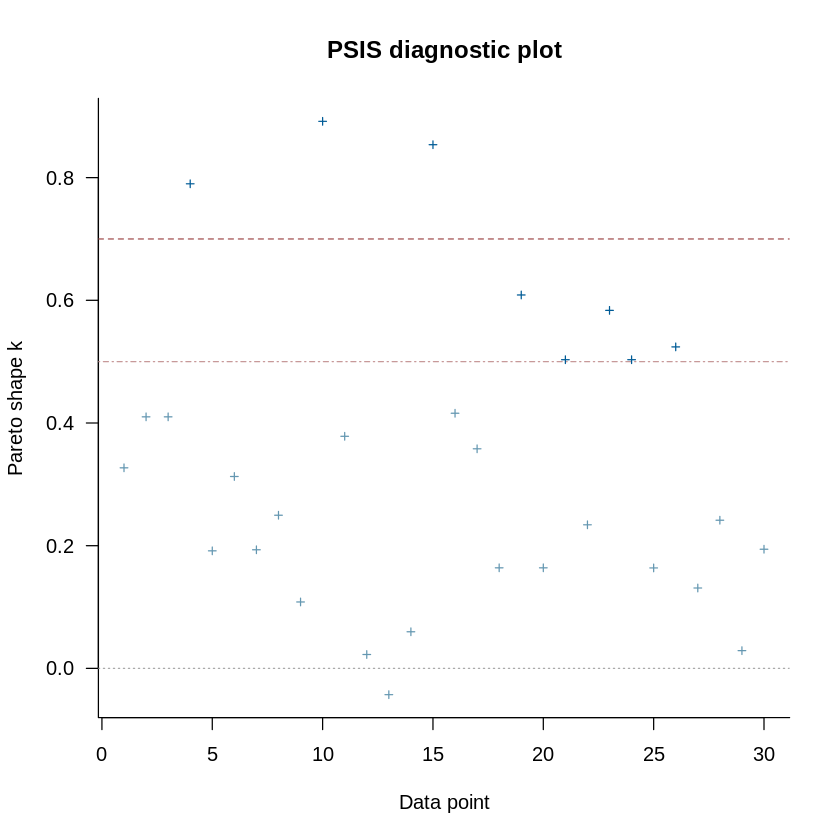

In [50]:
plot(loo_output)

### 3.

The effective number of parameters is computed as:

$$
\text{lppd} − \text{lppd}_{\text{loo−cv}} 
$$

In [73]:
lppd <- colLogSumExps(posterior_draws)
lppd <- sum(lppd) - 30 * log(4000)

In [74]:
lppd_loocv <- loo_output$elpd_loo

Warning message:
“Accessing elpd_loo using '$' is deprecated and will be removed in a future release. Please extract the elpd_loo estimate from the 'estimates' component instead.”


In [76]:
peff = lppd - lppd_loocv
peff

[1] 9.450118

### 4.

From $30$ samples, $22$ have a value of $k < 0.5$, $5$ have a value between $0.5$ and $0.7$, and $3$ have a value between $0.7$ and $1$.

In this particular case we have $3$ cases with a value of $k$ greater than $0.7$, which attending to the paper implies that the importance sampler estimator is unreliable since it might have high bias and high variance, and we should draw many more samples from the full posterior. So in this particular cases it might be better to run MCMC again or to try and draw more samples from the posterior and check the value of $k$.

## Pooled model

### 1.

In [77]:
## Set path to model
file  <- file.path("stan_files", "factory", "pooled_d.stan")
model <- cmdstan_model(file)

model$print()

//  Author: * Juan Maroñas *
//  This file implements the pooled model in assignment 7 exercise 2 part d. We change the prior over hyperparameters

data {

  int<lower=0> N;
  int<lower=0> J;
  matrix[N,J]  y; // cannot be array of vectors otherwise when normalizing cannot use - since is not defined between arrays and scalars.

}

transformed data {

  vector[N*J] y_resh; // to reshape the matrix into a vector
  y_resh = to_vector(y);

  // normalize the data so that standard prior is correctly specified.
  vector [N*J] y_std;

  y_std = (y_resh - mean(y_resh)) / sd(y_resh);

}

parameters {

  real mu;
  real<lower=0> sigma;

}

model {

  // priors
  mu ~ normal(0,10);
  sigma ~ gamma(1,1);

  // likelihood
  y_std ~ normal( mu , sigma );

}

generated quantities {

  // Compute log predictive density \log p(y*|0s) per each datapoint and per each sample
  vector[N*J] log_lik;
  for ( i in 1:N*J ){
        log_lik[ i ] = normal_lpdf( y_std[i] | mu, sigma );
  }


}


In [78]:
## MCMC sampling

# Data specified in the data module
data_list <- list(
                    y = factory,
                    N = nrow(factory),
                    J = ncol(factory)
                  )

fit <- model$sample(
                      data            = data_list, 
                      seed            = 123, 
                      chains          = 4, 
                      parallel_chains = 4,
                      refresh         = 500,  # print update every 500 iters
                      step_size       = 0.1   # set initial step size otherwise getting scale parameter being 0 and
                                              # this is not possible since it is contrained. So there is a huge step
                                              # size during warm up that makes dynamics go into this region.
                    )

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 3 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 3 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 3 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Ite

### 2.

In [84]:
## extract the log likelihood matrix 
posterior_draws <- fit$draws("log_lik", format = 'df')[,0:30]
posterior_draws <- data.matrix(posterior_draws)

Warning message:
“Dropping 'draws_df' class as required metadata was removed.”


In [85]:
loo_output <- loo(posterior_draws)
loo_output

Warning message:
“Relative effective sample sizes ('r_eff' argument) not specified.
For models fit with MCMC, the reported PSIS effective sample sizes and 
MCSE estimates will be over-optimistic.”
Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”



Computed from 4000 by 30 log-likelihood matrix

         Estimate  SE
elpd_loo    -44.2 4.4
p_loo         2.1 0.8
looic        88.5 8.8
------
Monte Carlo SE of elpd_loo is 0.0.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     29    96.7%   2670      
 (0.5, 0.7]   (ok)        1     3.3%   948       
   (0.7, 1]   (bad)       0     0.0%   <NA>      
   (1, Inf)   (very bad)  0     0.0%   <NA>      

All Pareto k estimates are ok (k < 0.7).
See help('pareto-k-diagnostic') for details.

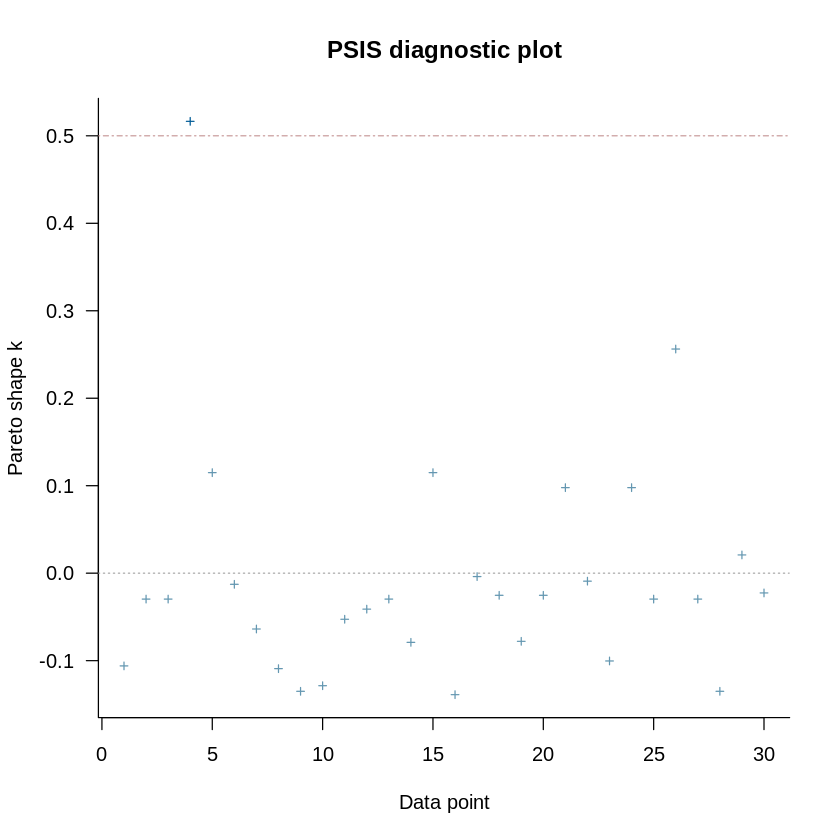

In [87]:
plot(loo_output)

### 3.

The effective number of parameters is computed as:

$$
\text{lppd} − \text{lppd}_{\text{loo−cv}} 
$$

In [88]:
lppd <- colLogSumExps(posterior_draws)
lppd <- sum(lppd) - 30 * log(4000)

In [89]:
lppd_loocv <- loo_output$elpd_loo

Warning message:
“Accessing elpd_loo using '$' is deprecated and will be removed in a future release. Please extract the elpd_loo estimate from the 'estimates' component instead.”


In [90]:
peff = lppd - lppd_loocv
peff

[1] 2.082591

### 4.

In this particular case all the values of $k$ are below $0.7$ which means that the importance sampling estimates are reliable.

## Hierarchical

### 1.

In [91]:
## Set path to model
file  <- file.path("stan_files", "factory", "hierarchical_d.stan")
model <- cmdstan_model(file)

model$print()

//  Author: * Juan Maroñas *
//  This file implements the hierarchical model in assignment 7 exercise 2 with a more non-informative hyperprior.

data {

  int<lower=0> N;
  int<lower=0> J;
  matrix[N,J]  y; // cannot be array of vectors otherwise when normalizing cannot use - since is not defined between arrays and scalars.
}

transformed data {
  // normalize the data so that standard prior is correctly specified.
  matrix[N,J] y_std;

  for (j in 1:J){
    y_std[,j]  = (y[,j] - mean(y[,j]))  / sd(y[,j]);
  }
}

parameters {

  // likelihood parameters
  vector[J] mu;
  real<lower=0> sigma;

  // prior parameters
  real mu_0;
  real<lower=0> sigma_0;
  real<lower=0> tau;
}

model {

  // hyperpriors distributions
  sigma_0 ~ gamma(1,1);
  tau     ~ gamma(1,1);
  mu_0    ~ normal(0,10);

  // priors
  sigma ~ inv_chi_square( tau );
  for (j in 1:J){
    mu[j] ~ normal(mu_0, sigma_0);
  }

  // likelihood
  for (j in 1:J)
    y_std[,j] ~ normal(mu[j], sigma);
}

generated quantities {



In [92]:
## MCMC sampling

# Data specified in the data module
data_list <- list(
                    y = factory,
                    N = nrow(factory),
                    J = ncol(factory)
                  )

fit <- model$sample(
                      data            = data_list, 
                      seed            = 123, 
                      chains          = 4, 
                      parallel_chains = 4,
                      refresh         = 500,   # print update every 500 iters
                      # step_size       = 0.1  # Remove this since it implies 32 divergences. The default 
                                               # value is better
                      adapt_delta     = 0.95   ## This value is recommended here http://avehtari.github.io/BDA_R_demos/demos_rstan/cmdstanr_demo.html#8_comparison_of_k_groups_with_hierarchical_models
                                               #  when there is a small number of divergent transitions
                    )

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/RtmpwLtTvd/model-2202e72479fa7c.stan', line 35, column 2 to column 23)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 



Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Iteration:  500 / 2000 [ 25%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/RtmpwLtTvd/model-2202e72479fa7c.stan', line 35, column 2 to column 23)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 



Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 3 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 4 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 4 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 4 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 2 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 3 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 4 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 1 finished in 0.3 seconds.
Chain 2 finished in 0.4 seconds.
Chain 3 finished in 0.4 seconds.
Chain 4 finished in 0.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.3 seconds.
Total execution time: 0.4 seconds.



See https://mc-stan.org/misc/warnings for details.




### 2.

In [93]:
## extract the log likelihood matrix 
posterior_draws <- fit$draws("log_lik", format = 'df')[,0:30]
posterior_draws <- data.matrix(posterior_draws)

Warning message:
“Dropping 'draws_df' class as required metadata was removed.”


In [95]:
loo_output <- loo(posterior_draws)
loo_output

Warning message:
“Relative effective sample sizes ('r_eff' argument) not specified.
For models fit with MCMC, the reported PSIS effective sample sizes and 
MCSE estimates will be over-optimistic.”



Computed from 4000 by 30 log-likelihood matrix

         Estimate  SE
elpd_loo    -42.0 2.9
p_loo         2.4 0.4
looic        83.9 5.7
------
Monte Carlo SE of elpd_loo is 0.0.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

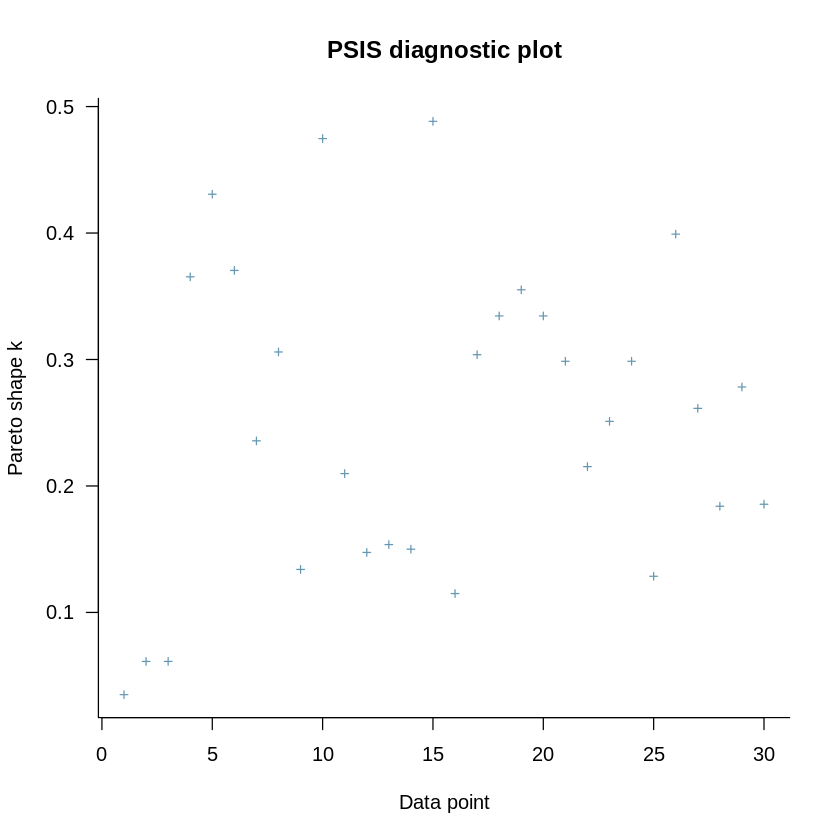

In [96]:
plot(loo_output)

### 3.

The effective number of parameters is computed as:

$$
\text{lppd} − \text{lppd}_{\text{loo−cv}} 
$$

In [97]:
lppd <- colLogSumExps(posterior_draws)
lppd <- sum(lppd) - 30 * log(4000)

In [98]:
lppd_loocv <- loo_output$elpd_loo

Warning message:
“Accessing elpd_loo using '$' is deprecated and will be removed in a future release. Please extract the elpd_loo estimate from the 'estimates' component instead.”


In [99]:
peff = lppd - lppd_loocv
peff

[1] 2.35646

### 4.

In this particular case all the values of $k$ are below $0.5$ which means that the importance sampling estimates are reliable.

### 5.

Comparing the Loo values obtained by the PSIS proceedure, we observe that the best model is the hierarchical model with a value of $-42$, followed by the pooled model with a value of $-44.2$, and finally the unpooled model with $-51.7$. The comparison between the hierarchical and pooled model is reliable since we have values of $k$ below $0.7$. In case of the unpooled model the loo value might have been affected by those samples with high importance weights that makes the estimator unreliable. In this case we could either run MCMC directly leaving out each of these samples with high value of $k$, or we could change the observation model, for example using a student-t, which would ensure that each of the samples affect less the estimation of the probability distribution. These particular samples with high value of $k$, which are making the posterior very different from the full posterior (reason for having very big importance weights), are samples very informative about the distribution to be estimated and so changing the observation model to a heavy tailed one can reduce these problems related to the unmatch between the full posterior and the loo posteriors.
